In [55]:
import pandas as pd
import numpy as np
import networkx as nx 

files_history = ["data/nltk/nltk_files_history.csv", "data/wagtail/wagtail_files_history.csv"]
commits_history = ["data/nltk/nltk_commits_history.csv", "data/wagtail/wagtail_commits_history.csv"]
files_columns = ["Repository", "Branches", "NbBranches", "OldFilePath", "FilePath", "FileName", "FileExtension", "FileType", 
                    "ChangeType", "NbMethods", "NbMethodsChanged", "NLOC", "Complexity", "NlocDivByNbMethods", 
                    "ComplexDivByNbMethods", "SATD", "SATDLine", "NbLinesAdded","NbLinesDeleted", "CommitId", "Author", "DateTime", 
                    "Date", "HourOfDay"]

files_pd = [pd.read_csv(file, header=None, names=files_columns) for file in files_history]
files_pd_all = pd.concat(files_pd)
files_pd_all["DateTime"] = pd.to_datetime(files_pd_all["DateTime"],format="%Y-%m-%d %H:%M:%S%z",utc=True)
commits_pd = [pd.read_csv(file) for file in commits_history]

# Plan

1. Create co-authorship graphs by file commit (commiting to the same file, within a certain time frame)
2. Count edges by time window, determine where it levels out (time to try - day, week, month, quarter)
3. Determine ideal time window, create graphs from this window
4. Extract network statistics for each timestep
5. Visualize these statistic over time

Note: Steps 3-5 can be done together (don't neceesarily need to create persistent graph objects)

In [184]:
import math

def rolling_with_name(df, nm, timescale):
    df_rolled = df.rolling(timescale, min_periods = 1).count().reset_index()
    df_rolled["Repository"] = nm[0]
    df_rolled["FileName"] = nm[1]
    df_rolled = df_rolled.rename(columns = {"Author": "count"}, errors = "raise")
    df_rolled["total_edges"] =  df_rolled["count"].apply(lambda x: math.comb(int(x), 2))
    total_ts = df_rolled.groupby(["Repository", "DateTime"]).agg({"total_edges": "sum"}).reset_index()
    total_ts["timescale"] = int(timescale.replace("D", ""))
    return  total_ts

def timescale_count_contributors(df, timescale):
    df = df[["Repository", "DateTime", "FileName", "Author"]]
    df = df.drop_duplicates()
    df = df.set_index(["DateTime"])
    df = df.sort_index()
    edge_counts_file = df.groupby(["Repository", "FileName"])
    edge_counts_rolling = [rolling_with_name(df, nm, timescale) for nm, df in edge_counts_file]
    return pd.concat(edge_counts_rolling)

In [185]:
time_intervals = ["1D", "3D", "7D", "14D", "30D", "60D", "90D"]
counts_by_time = [timescale_count_contributors(files_pd_all, interval) for interval in time_intervals]
counts_by_time_all = pd.concat(counts_by_time)
avg_counts_by_time_repo = counts_by_time_all.groupby(["timescale", "Repository"]).agg({"total_edges": "mean"}).reset_index()

In [187]:
counts_by_time_all

,Repository,DateTime,total_edges,timescale
0,nltk,2015-05-05 00:00:00+00:00,0,1
0,nltk,2007-12-13 00:00:00+00:00,1,1
1,nltk,2008-12-07 00:00:00+00:00,0,1
2,nltk,2011-05-26 00:00:00+00:00,0,1
3,nltk,2011-08-24 00:00:00+00:00,0,1
...,...,...,...,...
1,wagtail,2012-08-18 00:00:00+00:00,0,90
2,wagtail,2014-11-06 00:00:00+00:00,4,90
3,wagtail,2015-11-01 00:00:00+00:00,0,90
0,wagtail,2014-11-06 00:00:00+00:00,0,90


<AxesSubplot: xlabel='DateTime', ylabel='total_combos'>

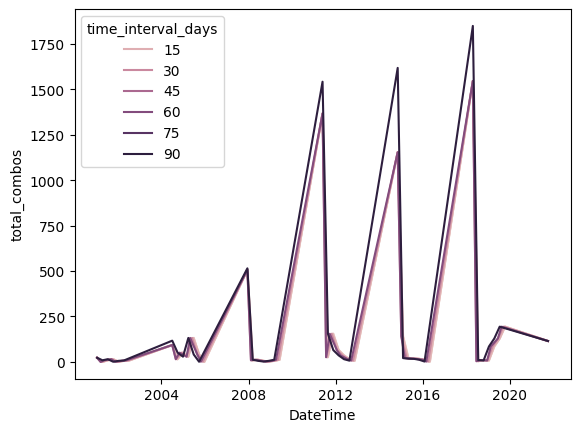

In [134]:
import seaborn as sns


sns.lineplot(x = "DateTime", y = "total_combos", hue = "time_interval_days", data = avg_counts_by_time_repo)


<AxesSubplot: xlabel='DateTime', ylabel='total_edges'>

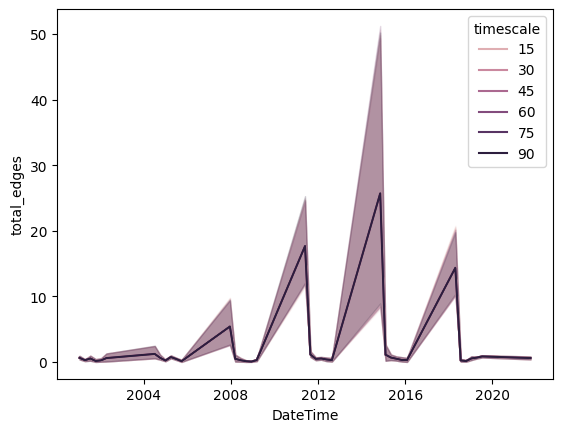

In [190]:

sns.lineplot(x = "DateTime", y = "total_edges", hue = "timescale", data = counts_by_time_all.query("Repository == 'nltk'"))
